In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Use DejaVu Serif as an alternative to Times New Roman
rcParams['font.family'] = 'DejaVu Serif'
rcParams['font.size'] = 12
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10


In [3]:
import os
import yaml
import json
import pandas as pd

def extract_experiment_data(root_dir):
    experiments = []
    
    for exp_name in os.listdir(root_dir):
        exp_path = os.path.join(root_dir, exp_name)
        if not os.path.isdir(exp_path):
            continue
        
        config_path = os.path.join(exp_path, 'config.yaml')
        json_files = [f for f in os.listdir(exp_path) if f.endswith('.json')]
        
        if not os.path.exists(config_path) or not json_files:
            continue
        
        results_path = os.path.join(exp_path, json_files[0])
        
        # Load config.yaml
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        
        # Load results.json
        with open(results_path, 'r') as f:
            results = json.load(f)
        
        # Extract relevant information
        exp_data = {
            "experiment": exp_name,
            "network": config.get("model", {}).get("type", "Unknown"),
            "loss_type": config.get("training", {}).get("loss", {}).get("loss_type", "Unknown"),
            "loss_params": config.get("training", {}).get("loss", {}).get("parameters", {}),
            "mIoU": results.get("segmentation_scores", {}).get("mIoU", None),
            "dice_mean": results.get("segmentation_scores", {}).get("dice_mean", None),
            "total_precision": results.get("detection_scores", {}).get("total_precision", None),
            "total_recall": results.get("detection_scores", {}).get("total_recall", None),
            "total_f1": results.get("detection_scores", {}).get("total_f1", None),
            "total_tp": results.get("detection_scores", {}).get("total_tp", None),
            "total_fp": results.get("detection_scores", {}).get("total_fp", None),
            "total_fn": results.get("detection_scores", {}).get("total_fn", None),
            "total_PQ": results.get("detection_scores", {}).get("total_recall", None)*results.get("segmentation_scores", {}).get("mIoU", None)
        }
        
        experiments.append(exp_data)
    
    # Convert to DataFrame
    df = pd.DataFrame(experiments)
    
    # Convert to JSON
    json_output = json.dumps(experiments, indent=4)
    
    return json_output, df


In [4]:
json_data, df_data = extract_experiment_data("experiments/runs")

In [5]:
df=df_data[["network","loss_type","loss_params","mIoU","dice_mean","total_precision","total_recall","total_f1","total_PQ"]]

In [6]:
df

,network,loss_type,loss_params,mIoU,dice_mean,total_precision,total_recall,total_f1,total_PQ
0,AttU_Net,tversky,"{'alpha': 0.2, 'beta': 0.8, 'gamma': 1.0}",0.703989,0.786023,0.748304,0.767453,0.757758,0.540279
1,R2U_Net,tversky,"{'alpha': 0.2, 'beta': 0.8, 'gamma': 1.0}",0.628859,0.702450,0.421721,0.769442,0.544829,0.483870
2,U_Net,tversky,"{'alpha': 0.3, 'beta': 0.7, 'gamma': 1.0}",0.718799,0.799428,0.802973,0.736672,0.768395,0.529520
3,U_Net,dicece,"{'alpha': 0.5, 'beta': 0.5, 'gamma': 1.0}",0.558702,0.622163,0.301670,0.899162,0.451770,0.502363
4,U_Net,tversky,"{'alpha': 0.2, 'beta': 0.8, 'gamma': 1.0}",0.705719,0.787784,0.756317,0.774571,0.765335,0.546629
5,U_Net,tversky,"{'alpha': 0.4, 'beta': 0.6, 'gamma': 1.0}",0.728428,0.808005,0.834597,0.703813,0.763646,0.512677
6,U_Net,tversky,"{'alpha': 0.2, 'beta': 0.8, 'gamma': 1.0}",0.412473,0.574472,0.756317,0.774571,0.765335,0.319490
7,U_Net,tversky,"{'alpha': 0.5, 'beta': 0.5, 'gamma': 1.0}",0.723759,0.802221,0.855737,0.686575,0.761879,0.496915
8,U_Net,dicece,"{'alpha': 0.5, 'beta': 0.5, 'gamma': 1.0, 'lam...",0.711123,0.792203,0.724032,0.760853,0.741986,0.541060
9,U_Net,dicece,"{'alpha': 0.5, 'beta': 0.5, 'gamma': 1.0, 'lam...",0.670619,0.752082,0.612854,0.806355,0.696413,0.540757


In [7]:
import pandas as pd

# Round numeric columns to 3 decimals
df = df.round(3)

# Filter only U-Net models
df_unet = df[df["network"]=="U_Net"].copy()

# Expand loss_params into separate columns
loss_params_df = df_unet["loss_params"].apply(pd.Series)

# Keep only the relevant parameters
df_unet = df_unet.drop(columns=["loss_params"]).join(loss_params_df)

# Add missing columns if not present
for param in ["alpha", "beta", "lambda_ce", "lambda_dice"]:
    if param not in df_unet:
        df_unet[param] = "-"

# Assign "-" where needed
df_unet.loc[df_unet["loss_type"] == "dicece", ["alpha", "beta"]] = None
df_unet.loc[df_unet["loss_type"] == "tversky", ["lambda_ce", "lambda_dice"]] = None

# Remove gamma column
df_unet = df_unet.drop(columns=["gamma"], errors="ignore")

# Reorder columns
column_order = ["network", "loss_type", "alpha", "beta", "lambda_ce", "lambda_dice", "mIoU", "dice_mean", "total_precision", "total_recall", "total_f1","total_PQ"]
df_unet = df_unet[column_order]
df_unet = df_unet.drop(3)
df_unet = df_unet.drop(6)
# Print final dataframe
df_unet

,network,loss_type,alpha,beta,lambda_ce,lambda_dice,mIoU,dice_mean,total_precision,total_recall,total_f1,total_PQ
2,U_Net,tversky,0.3,0.7,NaN,NaN,0.719,0.799,0.803,0.737,0.768,0.530
4,U_Net,tversky,0.2,0.8,NaN,NaN,0.706,0.788,0.756,0.775,0.765,0.547
5,U_Net,tversky,0.4,0.6,NaN,NaN,0.728,0.808,0.835,0.704,0.764,0.513
7,U_Net,tversky,0.5,0.5,NaN,NaN,0.724,0.802,0.856,0.687,0.762,0.497
8,U_Net,dicece,NaN,NaN,0.1,1.0,0.711,0.792,0.724,0.761,0.742,0.541
9,U_Net,dicece,NaN,NaN,0.2,1.0,0.671,0.752,0.613,0.806,0.696,0.541


In [8]:
# Define the target loss parameters to match
target_params = {'alpha': 0.2, 'beta': 0.8, 'gamma': 1.0}

# Convert loss_params column to dictionary if it's stored as string
df["loss_params"] = df["loss_params"].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Filter the DataFrame based on network names and loss_params
filtered_df = df[
    (df["network"].isin(["U_Net", "AttU_Net", "R2U_Net"])) &
    (df["loss_params"] == target_params)
]
# Reset index for cleaner output
filtered_df = filtered_df.reset_index(drop=True)
filtered_df.drop(3)

,network,loss_type,loss_params,mIoU,dice_mean,total_precision,total_recall,total_f1,total_PQ
0,AttU_Net,tversky,"{'alpha': 0.2, 'beta': 0.8, 'gamma': 1.0}",0.704,0.786,0.748,0.767,0.758,0.540
1,R2U_Net,tversky,"{'alpha': 0.2, 'beta': 0.8, 'gamma': 1.0}",0.629,0.702,0.422,0.769,0.545,0.484
2,U_Net,tversky,"{'alpha': 0.2, 'beta': 0.8, 'gamma': 1.0}",0.706,0.788,0.756,0.775,0.765,0.547


In [9]:
from src.inference.inference import SegInference
import torch
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda:7"
experiment_path = "experiments/runs/AttU_Net_Brightfield_2025-02-04_21-08-38"
seginf = SegInference(experiment_path,DEVICE)

In [10]:
from src.data_processing.dataset import iScatDataset
h5py_path = 'dataset/brightfield.hdf5'
dataset = iScatDataset(h5py_path,[0,1],normalize="zscore")
model = seginf.model
def predict(model,image,device=DEVICE):
    pred_mask = model(image.unsqueeze(0).to(device))
    pred_mask = torch.sigmoid(pred_mask) > 0.5 #[batch_size, 1, height, width]
    #TODO :
         #continue ..
    return pred_mask
sample_indicies = [0,1000,2000,3000,4000,5000]  

# create a function that takes compute the seg mask for all the samples (using samples indicies and dataset) it should return the images, and their corresponding mask, and gt mask (dataset returns tuple (image,gt_mask) in cpu as np arrays

# create a function that takes images and their corresponding mask and plot a figure with subplots each row is a two column, first column is original image, 2nd is the image witht he overlay mask (number of rows should correspond to number of samples), put  a legend for gt and pred mask 

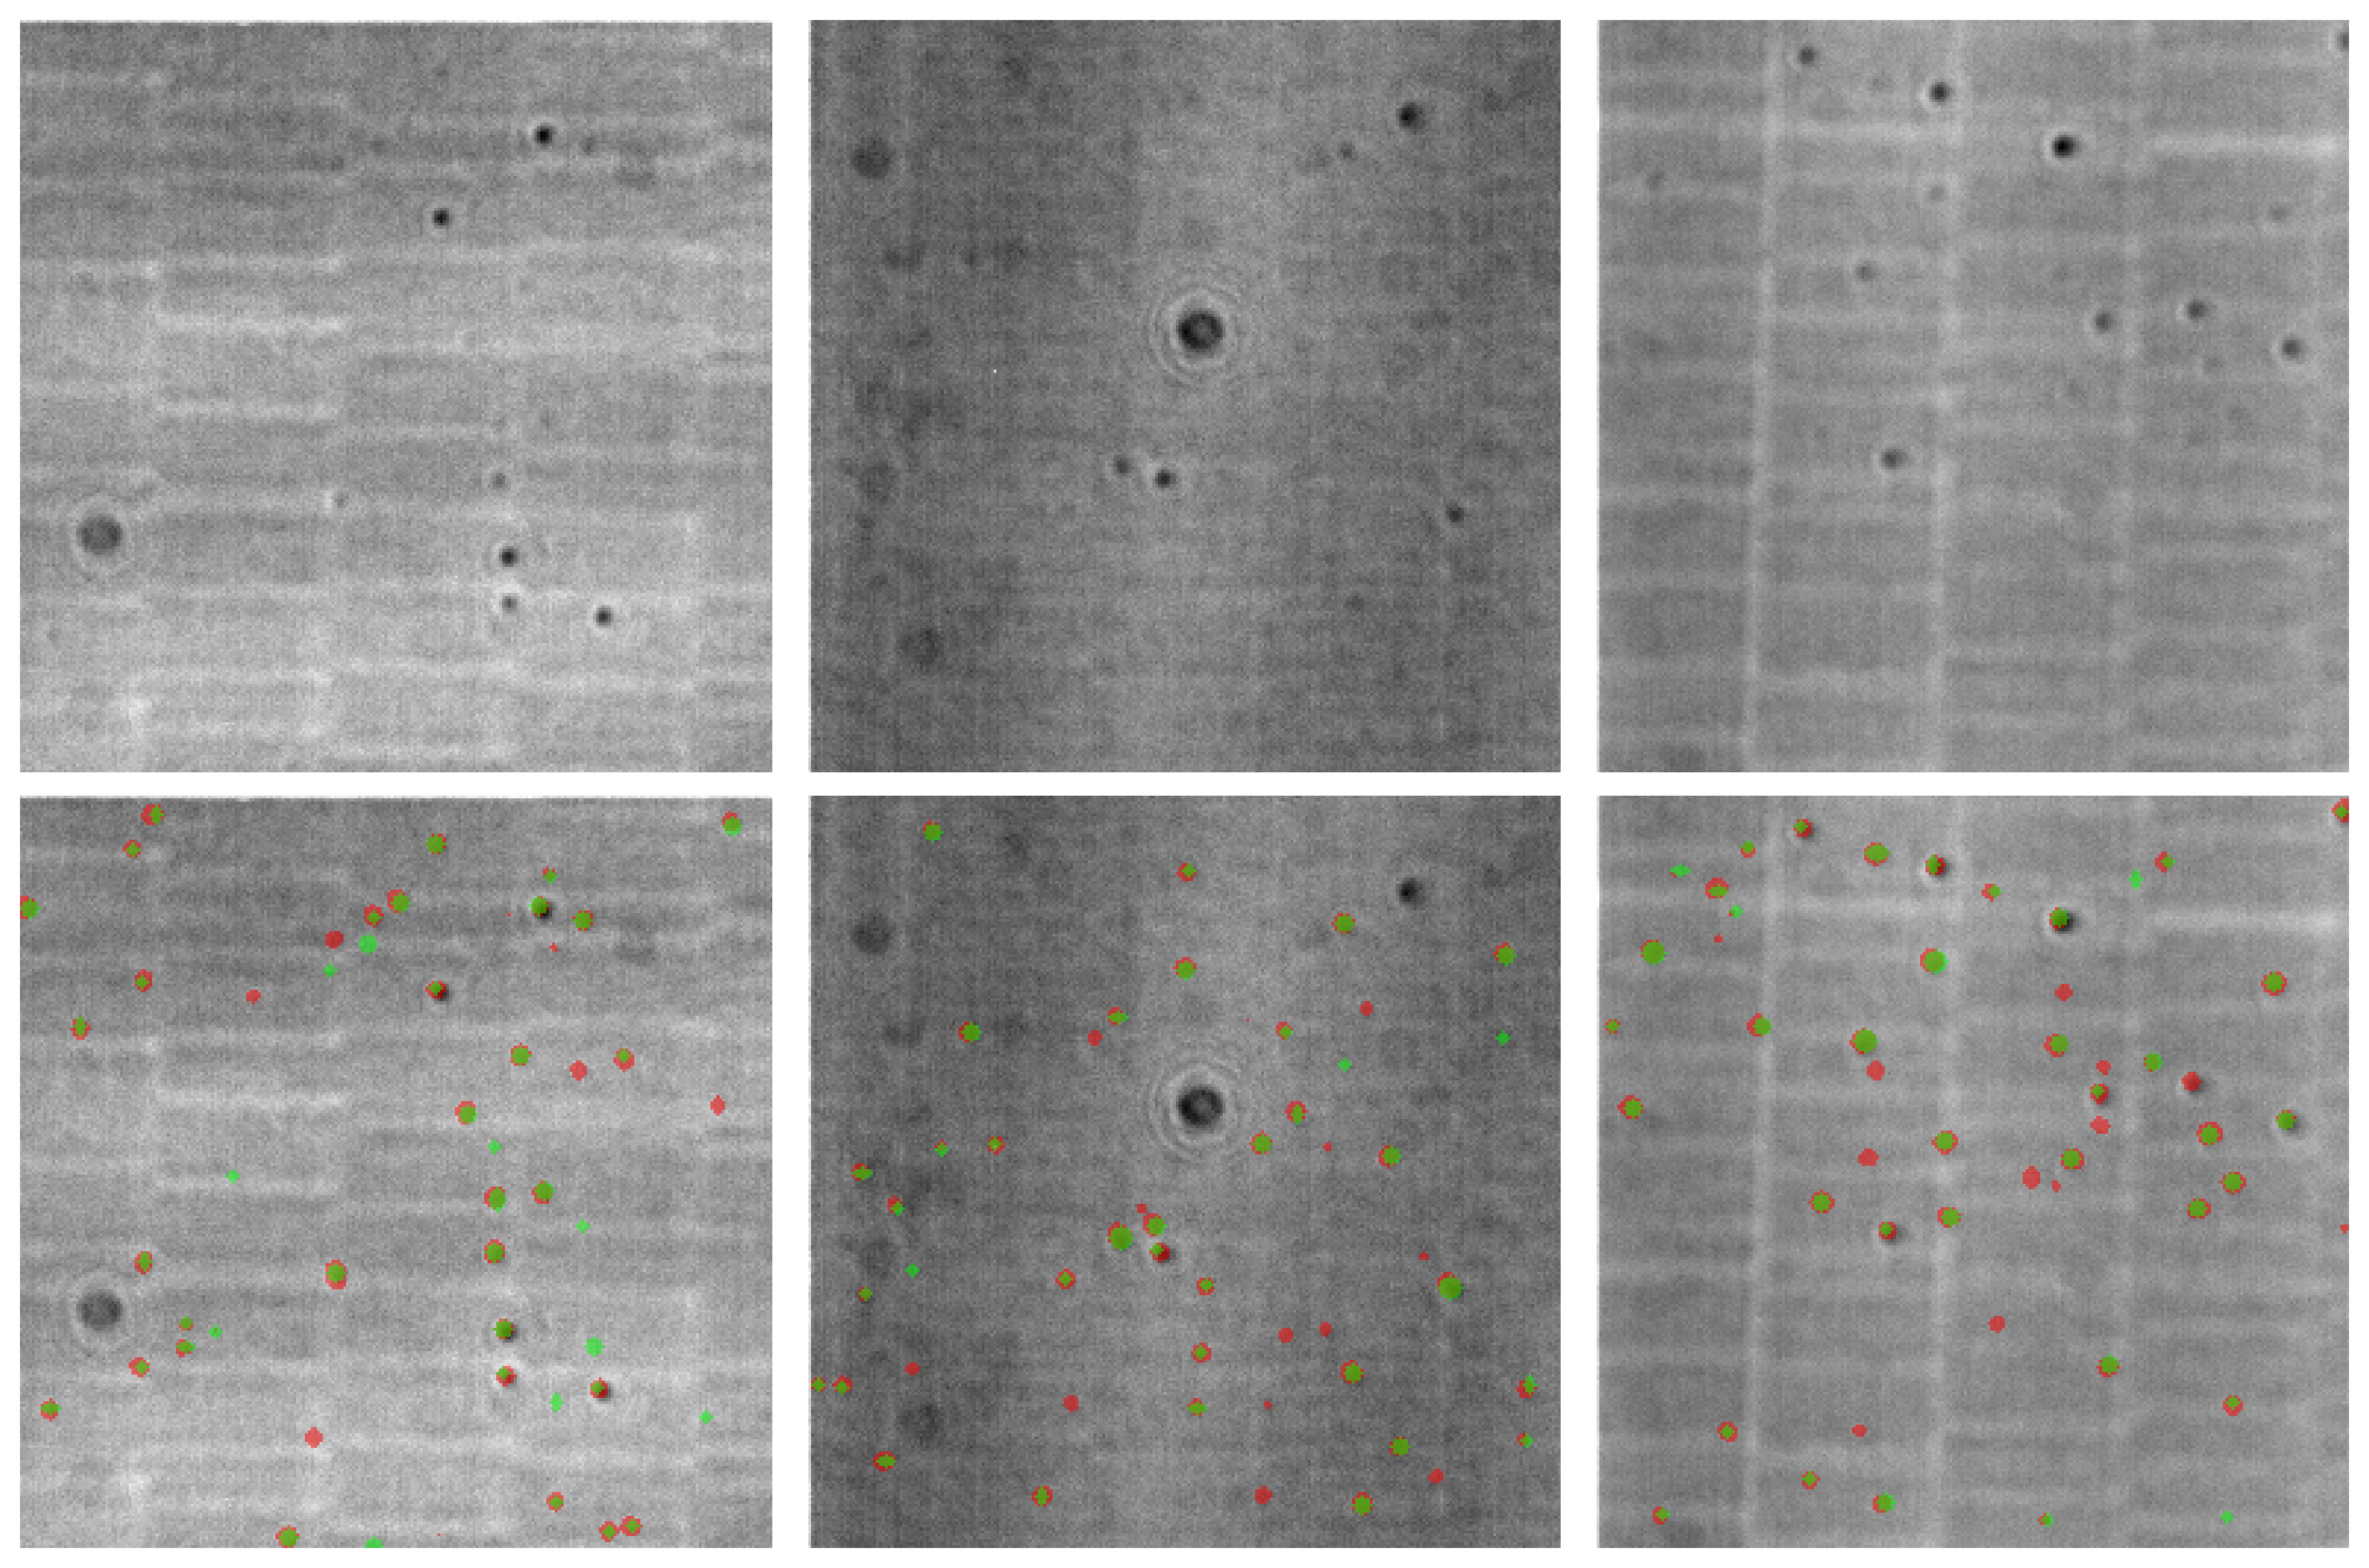

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from src.data_processing.dataset import iScatDataset

# Load dataset and model
h5py_path = 'dataset/brightfield.hdf5'
dataset = iScatDataset(h5py_path, [0, 1], normalize="zscore")
model = seginf.model
samples_idx = [2,100,200]

def rescale_image(img):
    """
    Rescales an image to the [0, 255] range for display.
    Assumes input is a 2D numpy array.
    """
    img = img.cpu().numpy()
    img_min = img.min()
    img_max = img.max()
    # Avoid division by zero if image is flat
    if img_max > img_min:
        img_norm = (img - img_min) / (img_max - img_min)
    else:
        img_norm = img - img_min
    return (img_norm * 255).astype(np.uint8)


def compute_segmentation_masks(model, dataset, sample_indices, device='cuda'):
    """
    Computes the segmentation masks for the provided sample indices.
    Returns lists of original images, predicted masks, and GT masks.
    """
    model.eval()
    images, pred_masks, gt_masks = [], [], []

    with torch.no_grad():
        for idx in sample_indices:
            # Get image and gt_mask from the dataset; assumed as numpy arrays
            image, gt_mask = dataset[idx]

            # Convert image to tensor using torch.from_numpy to avoid warnings
            # Assumes image is a numpy array of shape (C, H, W) e.g. (1, H, W)
            image_tensor = image.float().unsqueeze(0).to(device)
            
            # Compute prediction and threshold the sigmoid output
            pred_mask_tensor = model(image_tensor)
            pred_mask = (torch.sigmoid(pred_mask_tensor).cpu().numpy().squeeze() > 0.5)
            
            images.append(image)
            pred_masks.append(pred_mask)
            # If gt_mask is a tensor, convert it to numpy; otherwise, assume it's already numpy
            if torch.is_tensor(gt_mask):
                gt_masks.append(gt_mask.cpu().numpy())
            else:
                gt_masks.append(gt_mask)

    return images, pred_masks, gt_masks


def plot_segmentation_results(images, pred_masks, gt_masks):
    """
    Plots the segmentation results.
    First row: Original images.
    Second row: Original images with overlay of predicted (red) and GT (green) masks.
    """
    num_samples = len(images)
    fig, axes = plt.subplots(2, num_samples, figsize=(4 * num_samples, 8),dpi=300)

    # Plot original images in the first row
    for j in range(num_samples):
        # Assuming images[j] shape is (1, H, W)
        img = images[j][0]
        img_disp = rescale_image(img)
        axes[0, j].imshow(img_disp, cmap='gray')
        # axes[0, j].set_title(f"Sample {j}")
        axes[0, j].axis("off")

    # Plot overlay images in the second row
    for j in range(num_samples):
        img = images[j][0]
        # Rescale image for display
        img_disp = rescale_image(img)
        
        # Convert grayscale to RGB
        rgb_img = np.stack([img_disp] * 3, axis=-1).astype(np.float32)

        pred = pred_masks[j]
        gt = gt_masks[j]

        # Create an overlay copy
        overlay = rgb_img.copy()

        # Define colors for masks (red for predicted, green for GT)
        red_color = np.array([255, 0, 0], dtype=np.float32)
        green_color = np.array([0, 255, 0], dtype=np.float32)

        alpha = 0.5  # Transparency factor

        # Overlay predicted mask in red
        mask_pred_indices = pred.astype(bool)
        overlay[mask_pred_indices] = (1 - alpha) * overlay[mask_pred_indices] + alpha * red_color

        # Overlay ground truth mask in green
        mask_gt_indices = gt.astype(bool)
        overlay[mask_gt_indices] = (1 - alpha) * overlay[mask_gt_indices] + alpha * green_color

        # Ensure valid uint8 range for display
        overlay = np.clip(overlay, 0, 255).astype(np.uint8)

        axes[1, j].imshow(overlay)
        # axes[1, j].set_title(f"Overlay {j}")
        axes[1, j].axis("off")

    # Create a custom legend for the overlays
    red_patch = mpatches.Patch(color='red', label='Predicted Mask')
    green_patch = mpatches.Patch(color='green', label='GT Mask')
    # Place the legend outside the subplots area
    # fig.legend(handles=[red_patch, green_patch], loc='upper right', bbox_to_anchor=(0.95, 0.95))
    
    plt.tight_layout()
    plt.savefig("segmentation_result.pdf", format="pdf", dpi=300)
    plt.show()


# Example usage:
images, pred_masks, gt_masks = compute_segmentation_masks(model, dataset, samples_idx, DEVICE)
plot_segmentation_results(images, pred_masks, gt_masks)


In [153]:
# image = dataset[2][0]
# # image = rescale_image(image[61:73,137:149])
# image = torch.stack([
#         torch.tensor(rescale_image(x_i)[61:73,137:149]) for x_i in image
#     ], dim=0)
# print(image.shape)
# plt.imshow(image[0],cmap="gray")
# import numpy as np
# import matplotlib.pyplot as plt

# # Generate a random (32,12,12) grayscale 3D volume (Replace this with your actual data)
# volume = image

# # Create figure
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Create a mesh grid for X and Y
# X, Y = np.meshgrid(np.arange(12), np.arange(12))

# # Plot each slice at different Z levels
# for i in [0,6,12,18,24,31]:  # Iterate over the 32 slices
#     Z = np.full_like(X, i)  # Set Z height
#     ax.plot_surface(X, Y, Z, facecolors=plt.cm.gray(volume[i]), rstride=1, cstride=1, shade=False)
# # ax.view_init(elev=0, azim=0) 
# # Labels
# ax.set_xlabel("X-axis")
# ax.set_ylabel("Y-axis")
# ax.set_zlabel("Z-axis (Slices)")
# ax.set_title("3D Visualization of Stacked Grayscale Images")

# plt.show()


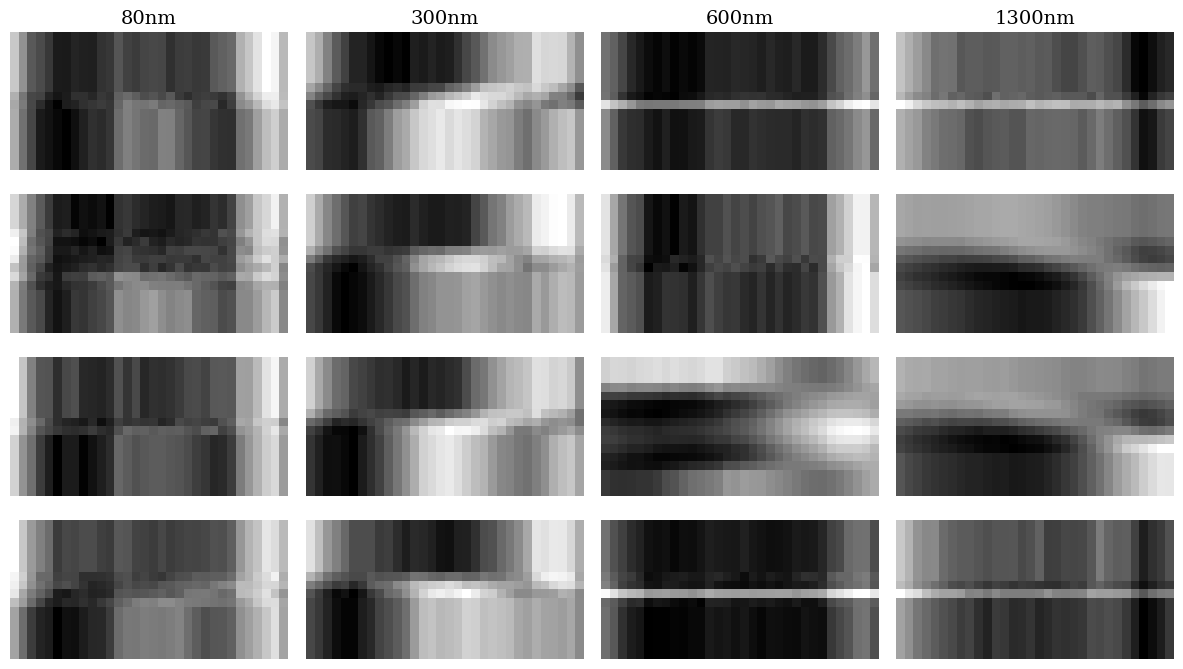

In [185]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Path to the dataset
particle_data_path = 'dataset/brightfield_particles.hdf5'

# Load data
with h5py.File(particle_data_path, 'r') as f:
    data = f['data'][:]
    labels = f['labels'][:]

# Define class labels
class_names = ['80nm', '300nm', '600nm', '1300nm']
num_classes = len(class_names)
num_samples = 4  # Number of samples per class

# Select samples for each class
selected_samples = []
for cls in range(num_classes):
    class_indices = np.where(labels == cls)[0]
    selected_indices = class_indices[:num_samples]
    selected_samples.append(data[selected_indices])

# Convert to numpy array for easier indexing
selected_samples = np.array(selected_samples)  # Shape: (num_classes, num_samples, H, W)

# Resize images to 16x32
resized_samples = np.array([resize(sample, (4,16, 32), preserve_range=True, anti_aliasing=True) for sample in selected_samples])
# Plot the samples
fig, axes = plt.subplots(num_samples, num_classes, figsize=(12, 7))
for i in range(num_samples):
    for j in range(num_classes):
        axes[i, j].imshow(resized_samples[j, i], cmap='gray')
        axes[i, j].axis('off')

# Add axis labels
for j in range(num_classes):
    axes[0, j].set_title(class_names[j])
for i in range(num_samples):
    axes[i, 0].set_ylabel(f'Sample {i+1}', rotation=90, labelpad=20)

plt.tight_layout()
plt.show()


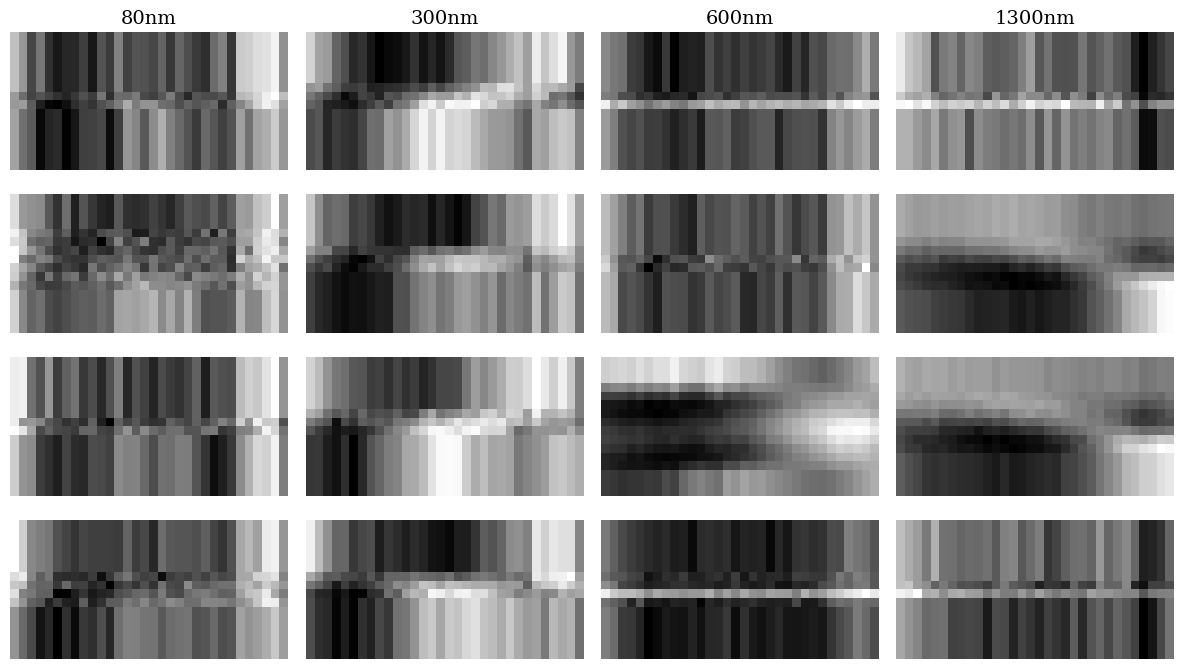

Resized samples array shape: (4, 4, 16, 32)


In [192]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Path to the dataset
particle_data_path = 'dataset/brightfield_particles.hdf5'

# Load data
with h5py.File(particle_data_path, 'r') as f:
    data = f['data'][:]
    labels = f['labels'][:]

# Define class labels and dimensions
class_names = ['80nm', '300nm', '600nm', '1300nm']
num_classes = len(class_names)
num_samples = 4
target_height = 16
target_width = 32

# Initialize array for resized samples
resized_samples = np.zeros((num_classes, num_samples, target_height, target_width))

# Select and resize samples for each class
for cls in range(num_classes):
    class_indices = np.where(labels == cls)[0]
    selected_indices = class_indices[:num_samples]
    
    for sample_idx, orig_idx in enumerate(selected_indices):
        # Get original image
        original_img = data[orig_idx]
        
        # Resize using cv2 with high-quality interpolation
        resized_img = cv2.resize(
            original_img, 
            (target_width, target_height), 
            interpolation=cv2.INTER_CUBIC
        )
        
        # Store in our resized array
        resized_samples[cls, sample_idx] = resized_img

# Plot the resized samples
fig, axes = plt.subplots(num_samples, num_classes, figsize=(12, 7))

for i in range(num_samples):
    for j in range(num_classes):
        axes[i, j].imshow(resized_samples[j, i], cmap='gray')
        axes[i, j].axis('off')

# Add axis labels
for j in range(num_classes):
    axes[0, j].set_title(class_names[j])
for i in range(num_samples):
    axes[i, 0].set_ylabel(f'Sample {i+1}', rotation=90, labelpad=20)

plt.tight_layout()
plt.show()

# Print the shape of the resized array to confirm dimensions
print(f"Resized samples array shape: {resized_samples.shape}")